## 1. 导包

In [18]:
import numpy as np
import tensorflow as tf

In [19]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import string
characters = string.digits + string.ascii_uppercase
width, height, string_len, classes = 32, 32, 1, len(characters) + 1

print(characters)
print(width, height, string_len, classes)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
32 32 1 37


In [154]:
from PIL import ImageFilter


class ImageCaptcha_v2(ImageCaptcha):
    def __init__(self, width=160, height=60, fonts=None, font_sizes=None, noise_dots_number=1):
        super().__init__(width, height, fonts, font_sizes)
        self.noise_dots_number = noise_dots_number

    def generate_image(self, chars):
        """Generate the image of the given characters.
        :param chars: text to be generated.
        """
        background = self.random_color(238, 255)
        noise_color = self.random_color(10, 200, random.randint(100, 150))
        font_color = self.random_color(10, 200, random.randint(230, 255))
        im = self.create_captcha_image(chars, font_color, background)
        self.create_noise_dots(im, noise_color, self.noise_dots_number)
        self.create_noise_curve(im, noise_color)
        im = im.filter(ImageFilter.SMOOTH)
        return im

    def random_color(self, start, end, opacity=None):
        red = random.randint(start, end)
        green = random.randint(start, end)
        blue = random.randint(start, end)
        if opacity is None:
            return (red, green, blue)
        return (red, green, blue, opacity)

In [155]:
def generator_fn(characters, string_len, width, height, font_sizes=(16, 18, 20, 22), sample_size=1000):
    """Return a function that takes no arguments and returns a generator.

    Args:
        characters: 字符集
        string_len: 一次结果的字符长度
        width, height: 图片验证码的 w, h
        font_sizes: 图片验证码中字符的字体大小
        sample_size: 数据集大小
    """
    captcha_gen_backend = ImageCaptcha_v2(width=width, height=height, font_sizes=font_sizes)
    def generator():
        for _ in range(sample_size):
            random_str = ''.join([random.choice(characters)
                                  for j in range(string_len)])
            x = np.array(captcha_gen_backend.generate_image(random_str)) / 255.0
            y = np.array([characters.find(x) for x in random_str])
            yield x, y
    return generator


In [156]:
gen = generator_fn(characters, string_len, width, height, sample_size=1)

V


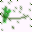

In [159]:
img, label = next(gen())
print(characters[label[0]])
tf.keras.preprocessing.image.array_to_img(img)

In [7]:
sample_size = 10
batch_size = 5
epochs = 2

In [8]:
x_shape = (width, height, 3)
y_shape = ()

In [9]:
# Prepare model.
tf.keras.backend.clear_session()
with strategy.scope():
    model = tf.keras.applications.VGG16(weights=None, input_shape=x_shape, classes=classes)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [10]:
# distribute.MirroredStrategy 在 tf2.4 中需要设置 AutoShardPolicy.DATA
# 否则 Error: Did not find a shardable source, walked to a node which is not a dataset
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

gen = generator_fn(characters, string_len, width, height, sample_size=sample_size)
dataset = tf.data.Dataset.from_generator(
    generator=gen,
    # tf2.4 之后将添加 output_signature 参数，未来会遗弃 output_types, output_shapes
    output_types=(tf.float32, tf.int32),
    output_shapes=(tf.TensorShape(x_shape), tf.TensorShape(y_shape))
).with_options(options)\
.batch(batch_size)\
.prefetch(tf.data.AUTOTUNE)

In [11]:
# Train. Do not specify batch size because the dataset takes care of that.
model.fit(
    dataset,
    epochs=epochs,
    workers=2,
    use_multiprocessing=True,
)

Epoch 1/2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2/2 [==============================] - 5s 31ms/step - loss: 4.1442
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 4.1350
